# Demo1: Flight Delay Prediction

In this tutorial, we use the popular [Flights Dataset](http://stat-computing.org/dataexpo/2009/the-data.html) to analyze and predict flight delays in airports based on past flight records. We show how you can use __Jupyter Notebook and Local Spark__ to read, explore, analyze and visualize your results. 

For this dataset, we will only look at the flights in 2007 - this is still 7 million flights! 

In this notebook, we will build **a classification model to predict airline delay from historical flight data.**  

First, we import some Python packages that we need:

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
%matplotlib inline

### Import data
To import data into your Data Scientist Workbench (DSWB), you can take either one of these actions:

1) Paste the following link into the sidebar of your DSWB:
https://share.datascientistworkbench.com/#/api/v1/workbench/10.115.89.160/shares/QBNwgXam7veFKl7/airline2007.csv

OR

2) Run the following cell to download it directly to you DSWB.

In [2]:
#Will download airline2007.csv if file not yet downloaded

if os.path.isfile("/resources/airline2007.csv") != True:
    #If file does not already exist, download it, unzip, then delete zipped file
    !wget --quiet --output-document  /resources/airline2007.csv.bz2 http://stat-computing.org/dataexpo/2009/2007.csv.bz2
    !bzip2 -d /resources/airline2007.csv.bz2
    !rm /resources/airline2007.csv.bz2
    print "Downloaded to /resources/airline2007.csv"
else:
    #If file already exists
    print "airline2007.csv already exists under /resources/airline2007.csv"
    print "You can continue to the next cell."


bzip2: I/O or other error, bailing out.  Possible reason follows.
bzip2: No such file or directory
	Input file = /resources/airline2007.csv.bz2, output file = /resources/airline2007.csv
rm: cannot remove ‘/resources/airline2007.csv.bz2’: No such file or directory
Downloaded to /resources/airline2007.csv


In [3]:
textFile = sc.textFile('/resources/airline2007.csv')

### Cleaning data
In this section, we remove the header of file

In [4]:
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()

textRDD = textFileRDD.filter(lambda r: r != header)

### Creating the Dataframe from RDD
A DataFrame is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in Python, but with richer optimizations under the hood.

In [5]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[4])), \
          CRSDepTime=int(r[5]),\
          ArrTime=int(float(r[6])),\
          CRSArrTime=int(r[7]), \
          UniqueCarrier=r[8],\
          DepDelay=int(float(r[15])),\
          Origin=r[16],\
          Dest=r[17], \
          Distance=int(float(r[18])))  
    except:
        x=None  
    return x

rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
sqlContext = SQLContext(sc)
airline_df = sqlContext.createDataFrame(rowRDD)

In this section, we add a new column to our data frame, **DepDelayed**, a binary variable:
- **True**, for flights that have > 15 minutes of delay
- **False**, for flights that have <= 15 minutes of delay

We will later use **Depdelayed** as the target/label column in the classification process.

In [6]:
airline_df = airline_df.withColumn('DepDelayed', airline_df['DepDelay']>15)

We also add a new column, __Hour__, to determine the hour of flight (0 to 24).

In [7]:
!rm -f ./metastore_db/*.lck

In [8]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
sqlContext.udf.register("hour_ex_py",hour_ex, IntegerType())
f_udf = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f_udf(airline_df.CRSDepTime))
airline_df.registerTempTable("airlineDF")

## Exploration
Let's do some exploration of this dataset.  
### Exploration: Which Airports have the Most Delays?

In [9]:
groupedDelay = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF \
                                GROUP BY Origin")

df_origin = groupedDelay.toPandas()

__Notice:__ To map each Airport to corresponding _Long_ and _Lat_, run the following cell to download the needed dataset.

In [10]:
# Will download airports.dat if not found in /resources/

if os.path.isfile("/resources/data/airports.dat") != True:
    #If file does not already exist, download it
    !wget  --quiet --output-document /resources/data/airports.csv https://ibm.box.com/shared/static/7ou3682c93cpm2gjtu7o0tnijk17jt05.csv
    print "Downloaded to /resources/data/airports.csv"
else:
    #If file already exists
    print "airports.dat already exists under /resources/data/airports.csv"
    print "You can continue to the next cell."

Downloaded to /resources/data/airports.csv


In [11]:
df = pd.read_csv('/resources/data/airports.csv', index_col=0,\
names = ['name', 'city', 'country','IATA','ICAO','lat','lng','alt','TZone','DST','Tz','airport','OurAirports'], \
            header=0)

In [12]:
df_airports = pd.merge(df_origin, df, left_on = 'Origin', right_on = 'IATA')


In [13]:
df_airports.head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz,airport,OurAirports
0,IAH,197869,10.571995,George Bush Intercontinental Houston Airport,Houston,United States,IAH,KIAH,29.984400,-95.341400,97,-6,A,America/Chicago,airport,OurAirports
1,RFD,688,0.585756,Chicago Rockford International Airport,Rockford,United States,RFD,KRFD,42.195400,-89.097198,742,-6,A,America/Chicago,airport,OurAirports
2,GEG,15998,5.572322,Spokane International Airport,Spokane,United States,GEG,KGEG,47.619900,-117.533997,2376,-8,A,America/Los_Angeles,airport,OurAirports
3,YUM,3436,6.409197,Yuma MCAS/Yuma International Airport,Yuma,United States,YUM,KNYL,32.656601,-114.606003,213,-7,N,America/Phoenix,airport,OurAirports
4,TUS,27827,6.169979,Tucson International Airport,Tucson,United States,TUS,KTUS,32.116100,-110.941002,2643,-7,N,America/Phoenix,airport,OurAirports


In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.average(x))/np.std(x)

Plot the map:

Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


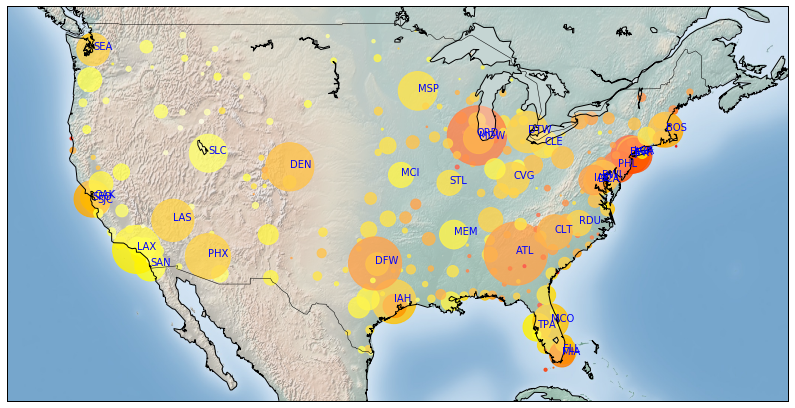

In [15]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#----- Scatter -------
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- Text -------
df_text=df_airports[(df_airports['conFlight']>60000) & (df_airports['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

### Exploration: Route delay

#### Which Routes are typically the most delayed?

In [16]:
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF \
                                GROUP BY Origin,Dest")
rout_Delay = grp_rout_Delay.toPandas()

In [17]:
df_airport_rout1 = pd.merge(rout_Delay, df, left_on = 'Origin', right_on = 'IATA')
df_airport_rout2 = pd.merge(df_airport_rout1, df, left_on = 'Dest', right_on = 'IATA')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]

Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


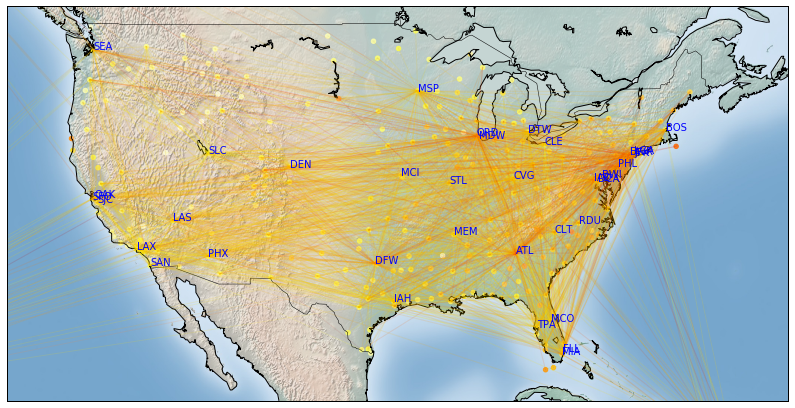

In [18]:
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, \
             color=colors[(row[5]*30).astype(int)] )
    

for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()



### Exploration: Airport Origin delay per month

Set the airport code name below to explore

In [19]:
Origin_Airport="JFK"

In [20]:
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE Origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(2)

+-------+----------+----------+---------+----------+--------+-------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|
+-------+----------+----------+---------+----------+--------+-------+----+
|   1608|      1621|      1435|        6|        13|     -19|   1416| CLE|
|   2223|      1955|      1750|        1|         1|     165|   2035| CLE|
+-------+----------+----------+---------+----------+--------+-------+----+
only showing top 2 rows



Let's look at flights originating from this airport:

In [21]:
print "total flights from this ariport: " + str(df_ORG.count())

total flights from this ariport: 122035


In this section, we group flights by month to see how delayed flights are distributed by month:

In [22]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,Month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,Month")
s = grp_carr.toPandas()

In [23]:
ps = s.pivot(index='Month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]

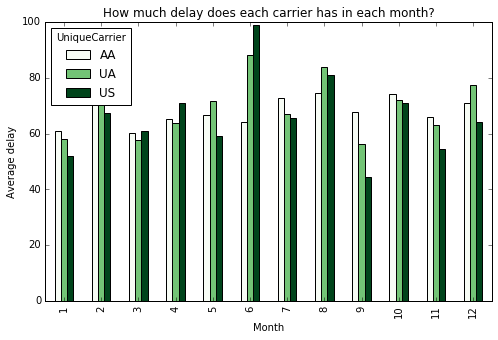

In [24]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Greens');
plt.xlabel('Month')
plt.ylabel('Average delay')
plt.title('How much delay does each carrier has in each month?')

We see that average delay in this year is is highest in June and August in this airport.

### Exploration: Airport Origin delay per day/hour

In [25]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay').groupby('DayOfWeek','hour').mean('DepDelay')

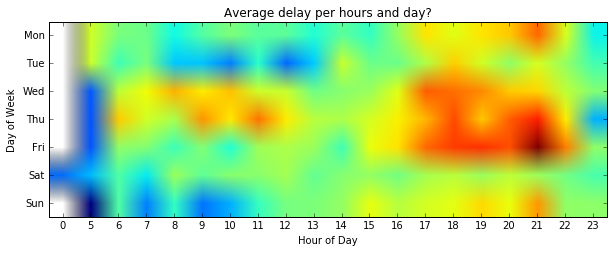

In [26]:
rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,24), X)
plt.yticks(range(0,7),['Mon','Tue','Wed','Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day?')
plt.imshow(Z)

Day of Week: 1 (Monday) - 7 (Sunday) 

A clear pattern here: flights tend to be delayed in these situations:  
- Later in the day (16 to 22): possibly because delays tend to pile up as the day progresses and the problem tends to compound later in the day.  
- Mornings in first day of week possibly because of more business meetings

## Modeling: Logistic Regression
In this section, we will build a supervised learning model to predict flight delays for flights leaving our selected airport.


### Preprocessing: Feature selection
In the next two cell we select the features that we need to create the model.

In [27]:
df_model=df_ORG
# stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
# model_stringIndexer = stringIndexer1.fit(df_model)
# indexedOrigin = model_stringIndexer.transform(df_model)
# encoder1 = OneHotEncoder(dropLast=False, inputCol="originIndex", outputCol="originVec")
# df_model = encoder1.transform(indexedOrigin)

In [28]:
stringIndexer2 = StringIndexer(inputCol="Dest", outputCol="destIndex")
model_stringIndexer = stringIndexer2.fit(df_model)
indexedDest = model_stringIndexer.transform(df_model)
encoder2 = OneHotEncoder(dropLast=False, inputCol="destIndex", outputCol="destVec")
df_model = encoder2.transform(indexedDest)

We use __labeled point__ to make local vectors associated with a label/response. In MLlib, labeled points are used in supervised learning algorithms and they are stored as doubles. For binary classification, a label should be either 0 (negative) or 1 (positive). 

In [29]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayOfWeek','hour','Distance','destVec'],
    outputCol = "features")
output = assembler.transform(df_model)
airlineRDD=output.map(lambda row: LabeledPoint([0,1][row['DepDelayed']],row['features']))

### Preprocessing: Spliting dataset into train and test dtasets

In [30]:
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])
#print str(trainRDD.count()) +"  "+ str(testRDD.count())

In [31]:
testRDD.take(1)

[LabeledPoint(0.0, (76,[0,1,2,3,4,5,43],[2007.0,1.0,30.0,2.0,17.0,425.0,1.0]))]

### Build the model

In [32]:
model = LogisticRegressionWithLBFGS.train(trainRDD)

## Model Evaluation

In [33]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))

In [34]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda (v, p): ((v, p),1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [35]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
print "Model Accuracy for JFK: %1.2f %%" % (Accuracy*100)

Model Accuracy for JFK: 72.62 %


### Use the model to predict your flight from JFK

You can use the following widget to query the model.  
For example the following flight has dely:  
    Month=2, Day=3, Hour=18, Dest=CLE

In [36]:
Destin = rout_Delay[rout_Delay['Origin']=='JFK'].Dest.unique()

@interact(Destination=tuple(Destin),Month=(1,12),DayOfWeek=(0,7),Hour=(0,23))
def g(Destination,Month,DayOfWeek,Hour):
    Distance=int(rout_Delay[(rout_Delay['Origin']=='JFK') & (rout_Delay['Dest']==Destination)]\
                 .avgDist.tolist()[0])
    testcase=Row(Year=2007.0,Month=Month,DayofMonth=2.0,DayOfWeek=DayOfWeek,hour=Hour,\
                 Origin='JFK',\
          Dest=Destination,Distance=Distance) 
    TestCase_df = sqlContext.createDataFrame(sc.parallelize([testcase]))
    t1= model_stringIndexer.transform(TestCase_df)
    t2=encoder2.transform(t1)
    p=model.predict(assembler.transform(t2).take(1)[0]['features'])
    print "Flight from JFK to "+Destination + ", Distance:" + str(Distance)
    if p==0:
        print "You flight doesnt have a delay, Accuracy= %1.2f %%" % (Accuracy*100)
    else:
        print "You flight may be delayed, Accuracy= %1.2f %%" % (Accuracy*100)


Flight from JFK to OAK, Distance:2576
You flight doesnt have a delay, Accuracy= 72.62 %


## Want to learn more?

<a href="https://bigdatauniversity.com/courses/what-is-spark/?utm_source=tutorial-flight-delay-demo&utm_medium=dswb&utm_campaign=bdu"><img src = "https://ibm.box.com/shared/static/r3pj5oo2ivnzqar0poj2eexiqrnvq6vy.png"> </a>


<h3>Authors:</h3>
<article class="teacher">
<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://ibm.box.com/shared/static/tyd41rlrnmfrrk78jx521eb73fljwvv0.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
<h4>Saeed Aghabozorgi</h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>
</article>
<article class="teacher">
<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone size-medium wp-image-2177" src="https://ibm.box.com/shared/static/2ygdi03ahcr97df2ofrr6cf8knq4kodd.jpg" alt="Polong Lin" width="300" height="300" /></div>
<h4>Polong Lin</h4>
<p>
<a href="https://ca.linkedin.com/in/polonglin">Polong Lin</a> is a Data Scientist at IBM in Canada. Under the Emerging Technologies division, Polong is responsible for educating the next generation of data scientists through Big Data University. Polong is a regular speaker in conferences and meetups, and holds a M.Sc. in Cognitive Psychology.</p>
</article>

<hr>
Copyright &copy; 2016 [Big Data University](https://bigdatauniversity.com/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​